In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session

from april.database import get_engine
from april.fs import PLOT_DIR
from april.utils import microsoft_colors
from april.utils import prettify_dataframe
from april.enums import Base, Strategy, Heuristic

sns.set_style('white')
pd.set_option('display.max_rows', 50)
%config InlineBackend.figure_format = 'retina'

In [2]:
out_dir = PLOT_DIR / 'isj-2019'
eval_file = out_dir / 'eval.pkl'

### Helper objects

In [3]:
synth_datasets = ['paper', 'p2p', 'small', 'medium', 'large', 'huge', 'gigantic', 'wide']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']
anonymous_datasets = ['real']
datasets = synth_datasets + bpic_datasets + anonymous_datasets
dataset_types = ['Synthetic', 'Real-life']

binet_ads = ["BINetv1", "BINetv2", "BINetv3"]
nn_ads = ["DAE"] + binet_ads
h_ads = nn_ads + [ "Likelihood+", "t-STIDE+", "Naive+"]
d_ads = ["Naive", "Sampling", "Likelihood", "OC-SVM"]
ads = h_ads + d_ads

heuristics = [r'$best$', r'$default$', r'$elbow_\downarrow$', r'$elbow_\uparrow$', 
              r'$lp_\leftarrow$', r'$lp_\leftrightarrow$', r'$lp_\rightarrow$']

## Retrieve evaluations from pickle file

In [4]:
evaluation = pd.read_pickle(eval_file)

### Add identifier for BPIC datasets and filter for ADs

In [5]:
evaluation = evaluation.query(f'ad in {ads} and label == "Anomaly"')

In [6]:
evaluation['perspective-label'] = evaluation['perspective'] + '-' + evaluation['label']
evaluation['attribute_name-label'] = evaluation['attribute_name'] + '-' + evaluation['label']
evaluation['dataset_type'] = 'Synthetic'
evaluation.loc[evaluation['process_model'].str.contains('bpic'), 'dataset_type'] = 'Real-life'
evaluation.loc[evaluation['process_model'].str.contains('real'), 'dataset_type'] = 'Real-life'

### Filter for best strategy

In `5.1 Best Strategy.ipynb` we find that $\tau_0$ and $\tau_a$ seem to work best overall. Intuatively it makes sense to set a threshold $\tau$ per attribute, hence we select $\tau_a$ whereever applicable.

In [7]:
_filtered_evaluation = evaluation.query(f'ad in {h_ads} and (strategy == "{Strategy.ATTRIBUTE}"'
                                       f' or (strategy == "{Strategy.SINGLE}" and process_model == "bpic12")'
                                       f' or (strategy == "{Strategy.SINGLE}" and ad == "Naive+")) or ad in {d_ads}')

### Filter for best heuristic

In `5.2 Best Heuristic.ipynb` we find that $lp_\rightarrow$ works best overall, aparat from DAE. For DAE we use $elbow_\uparrow$. For all default methods we use $default$.

In [8]:
filtered_evaluation = _filtered_evaluation.query(f'heuristic == "{Heuristic.DEFAULT}"'
                                                 f' or (heuristic == "{Heuristic.LP_MEAN}" and ad != "DAE")'
                                                 f' or (heuristic == "{Heuristic.ELBOW_UP}" and ad == "DAE")')

## Overall Evaluation

/home/timo.nolle/miniconda3/envs/ad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


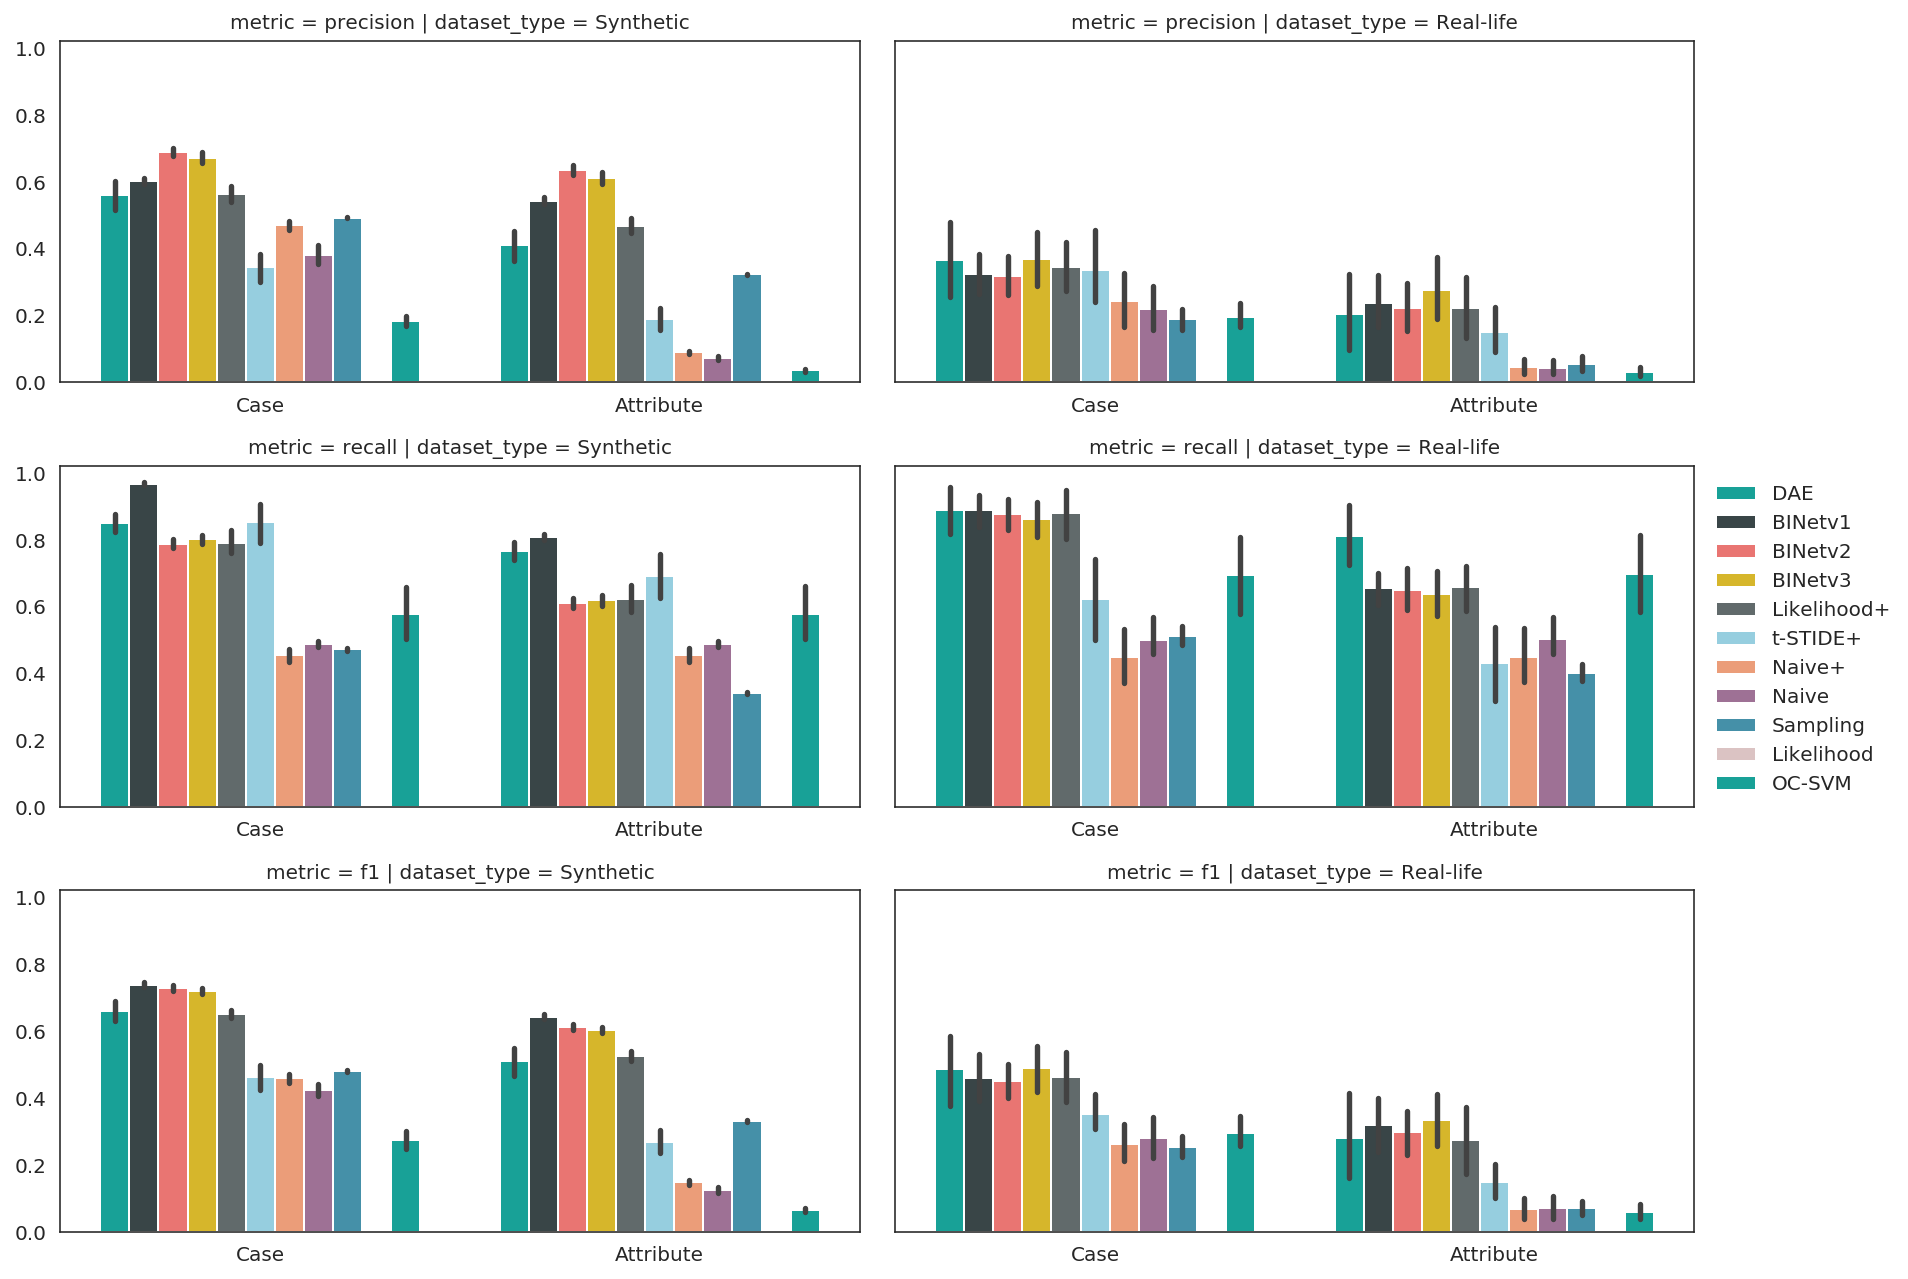

In [9]:
df = filtered_evaluation.query('axis in [0, 2]')
df = prettify_dataframe(df)
df = df.groupby(['axis', 'dataset_type', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['axis', 'dataset_type', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])

pdf = df.melt(id_vars=['axis', 'ad', 'dataset_type'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
g = sns.FacetGrid(data=pdf, row='metric', col='dataset_type', sharex=False, sharey=True, despine=False, aspect=2, col_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='axis', y='value', hue='ad', palette=microsoft_colors, hue_order=ads, order=['Case', 'Attribute'])
g = g.add_legend()

### Evaluation per perspective

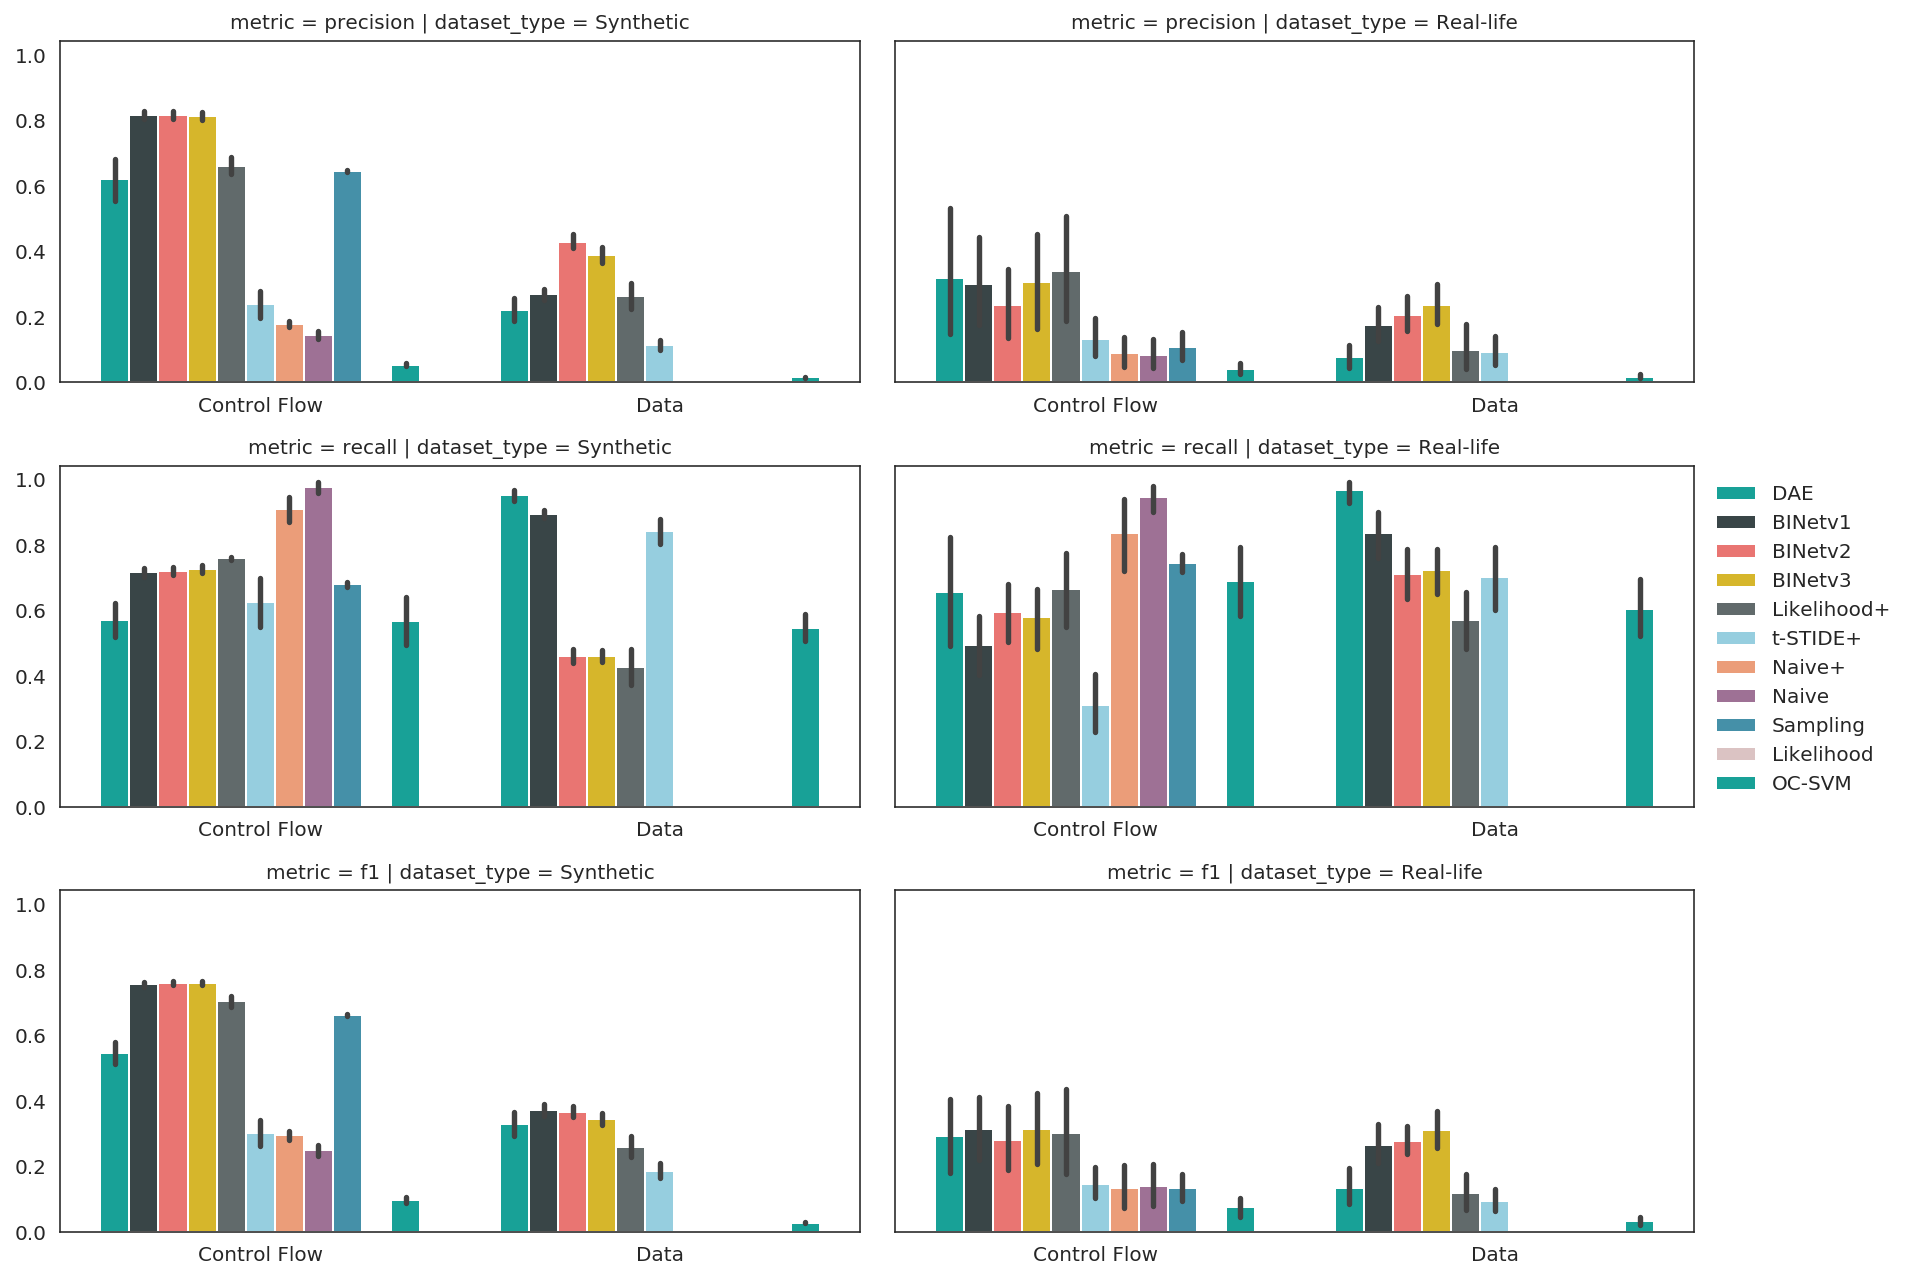

In [10]:
df = filtered_evaluation.query('axis == 2')
df = prettify_dataframe(df)
df = df.melt(id_vars=['ad', 'dataset_type', 'perspective'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
g = sns.FacetGrid(data=df, row='metric', col='dataset_type', sharex=False, sharey=True, despine=False, aspect=2, col_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='perspective', y='value', hue='ad', palette=microsoft_colors, hue_order=ads)
g = g.add_legend()

### Evaluation per attribute

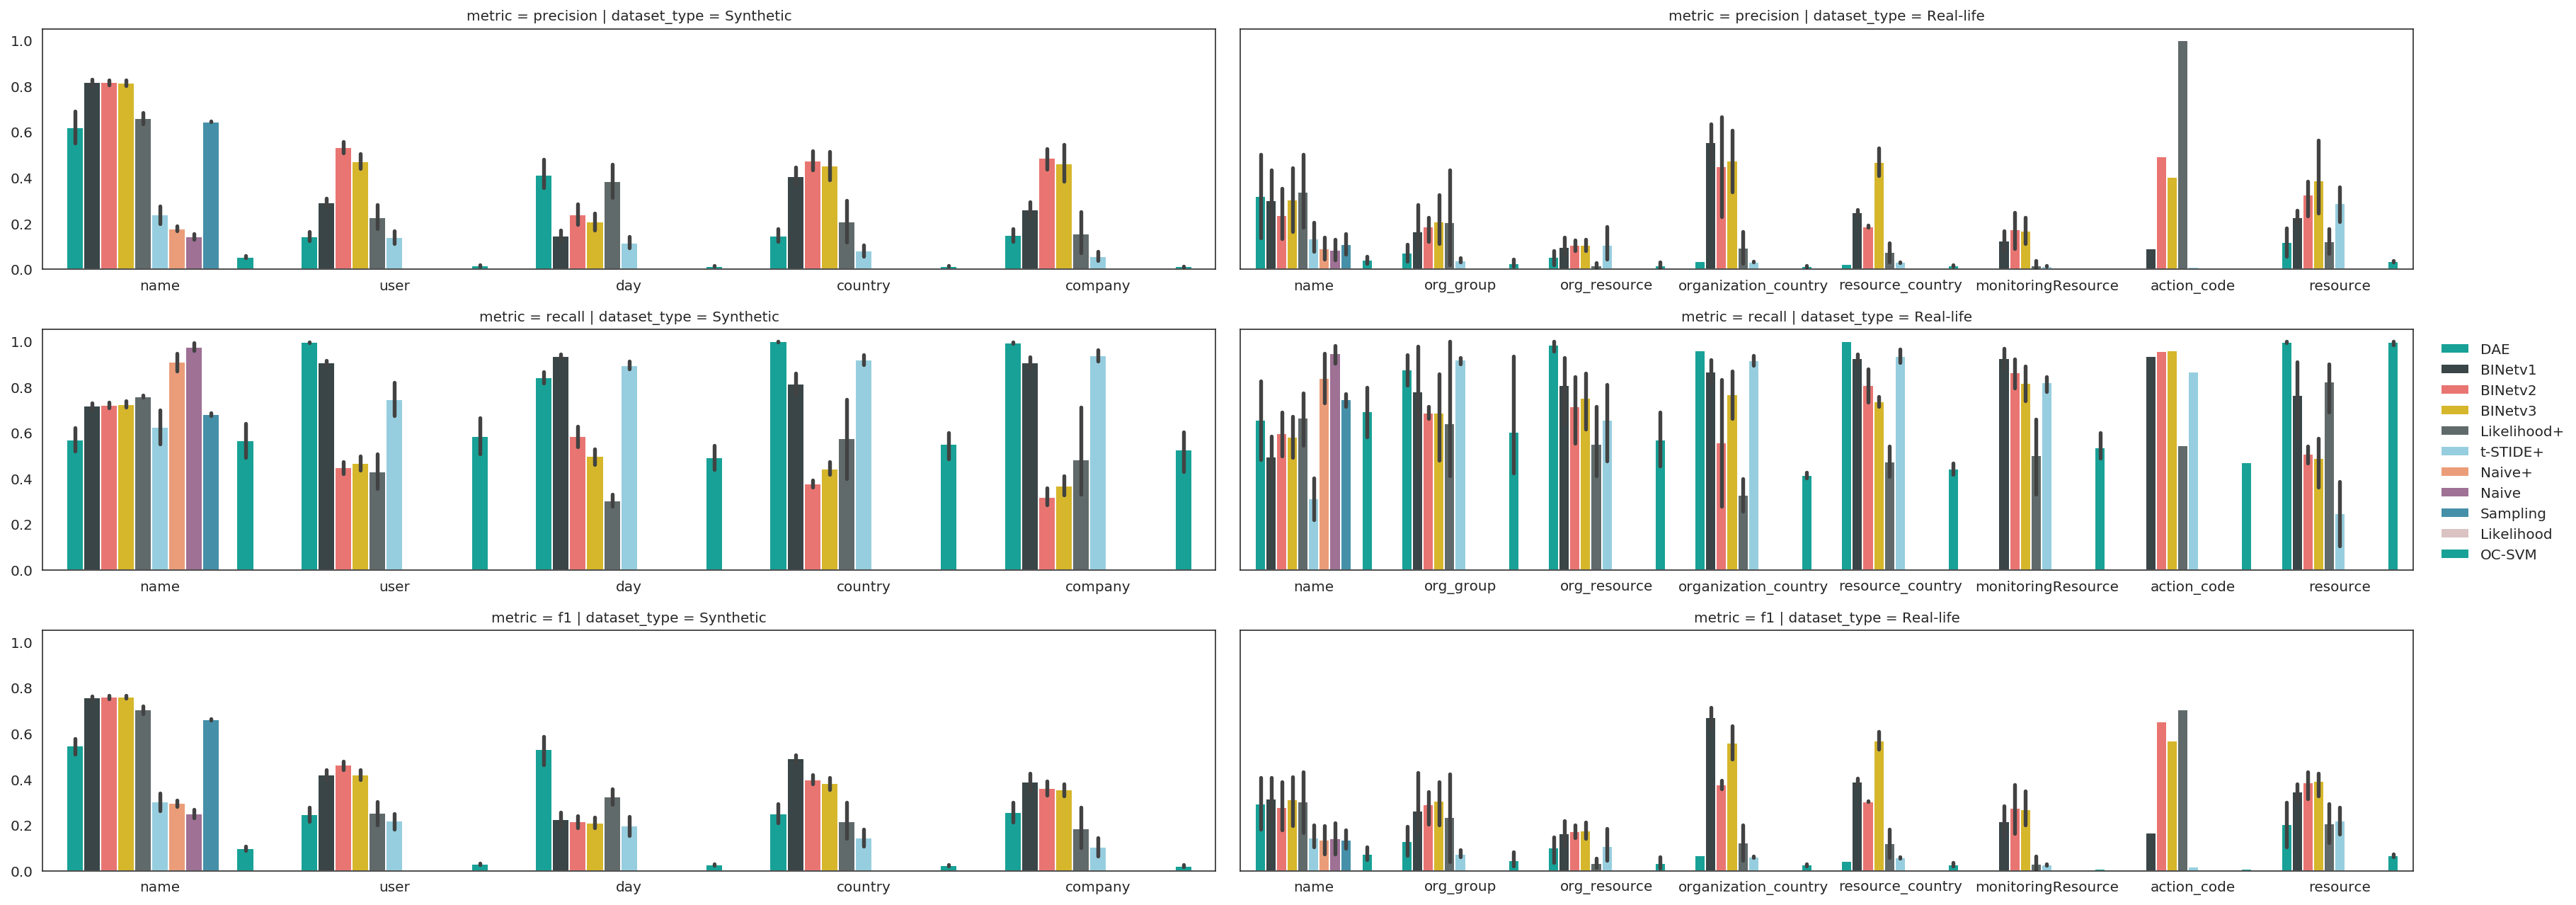

In [11]:
df = filtered_evaluation.query('axis == 2')
df = prettify_dataframe(df)
df = df.melt(id_vars=['ad', 'dataset_type', 'attribute_name'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
g = sns.FacetGrid(data=df, row='metric', col='dataset_type', sharex=False, sharey=True, despine=False, aspect=4, col_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='attribute_name', y='value', hue='ad', palette=microsoft_colors, hue_order=ads)
g = g.add_legend()

## Evaluation per Process Model on Synthetic Data

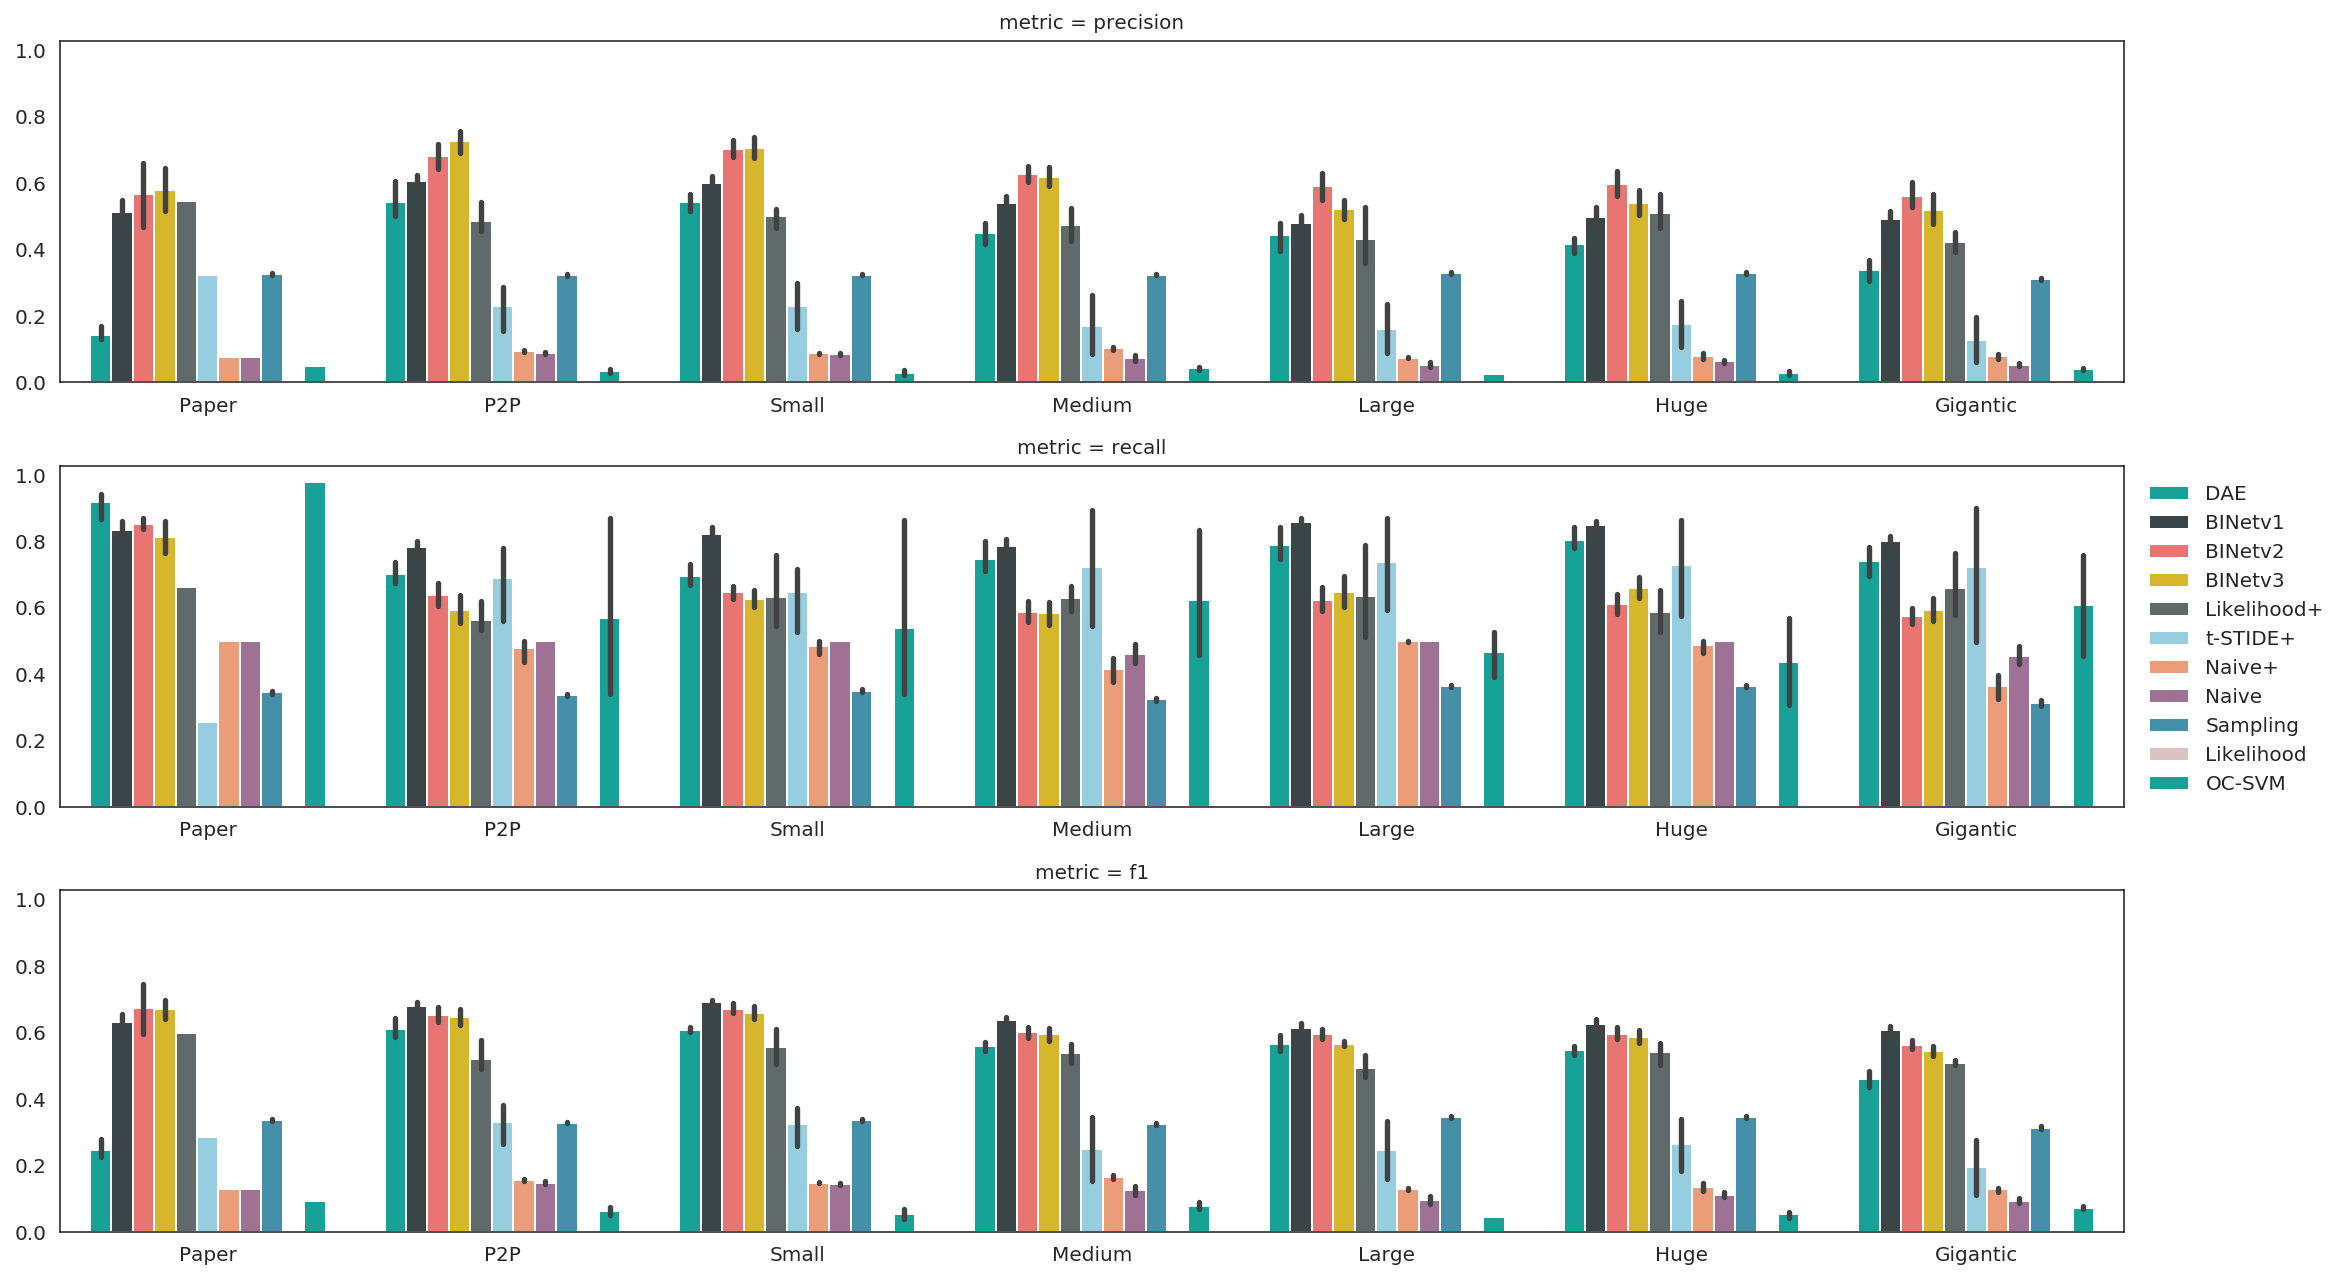

In [12]:
df = filtered_evaluation.query('axis == 2 and dataset_type == "Synthetic"')
df = prettify_dataframe(df)
df = df.groupby(['ad', 'file_name', 'process_model', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['ad', 'file_name', 'process_model'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])
df['f1'] = df['f1'].fillna(0)
df = df.melt(id_vars=['ad', 'process_model'], value_vars=['precision', 'recall', 'f1'], var_name='metric')

dataset_order = ['Paper', 'P2P', 'Small', 'Medium', 'Large', 'Huge', 'Gigantic']
g = sns.FacetGrid(data=df, row='metric', sharex=False, sharey=True, despine=False, aspect=5)
g = g.map_dataframe(sns.barplot, x='process_model', y='value', hue='ad', palette=microsoft_colors, hue_order=ads, order=dataset_order)
g = g.add_legend()

## Evaluation on Real data

In [13]:
df = filtered_evaluation.query(f'axis == 2 and dataset_type == "Real"')
df = prettify_dataframe(df)
df = df.groupby(['dataset_name', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['dataset_name', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])
df['f1'] = df['f1'].fillna(0)
df = df.melt(id_vars=['ad', 'dataset_name'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
g = sns.FacetGrid(data=df, row='metric', sharex=False, sharey=True, despine=False, aspect=5)
g = g.map_dataframe(sns.barplot, x='dataset_name', y='value', hue='ad', palette=microsoft_colors, hue_order=ads)
g = g.add_legend()

<Figure size 1088x0 with 0 Axes>

# Evaluation table

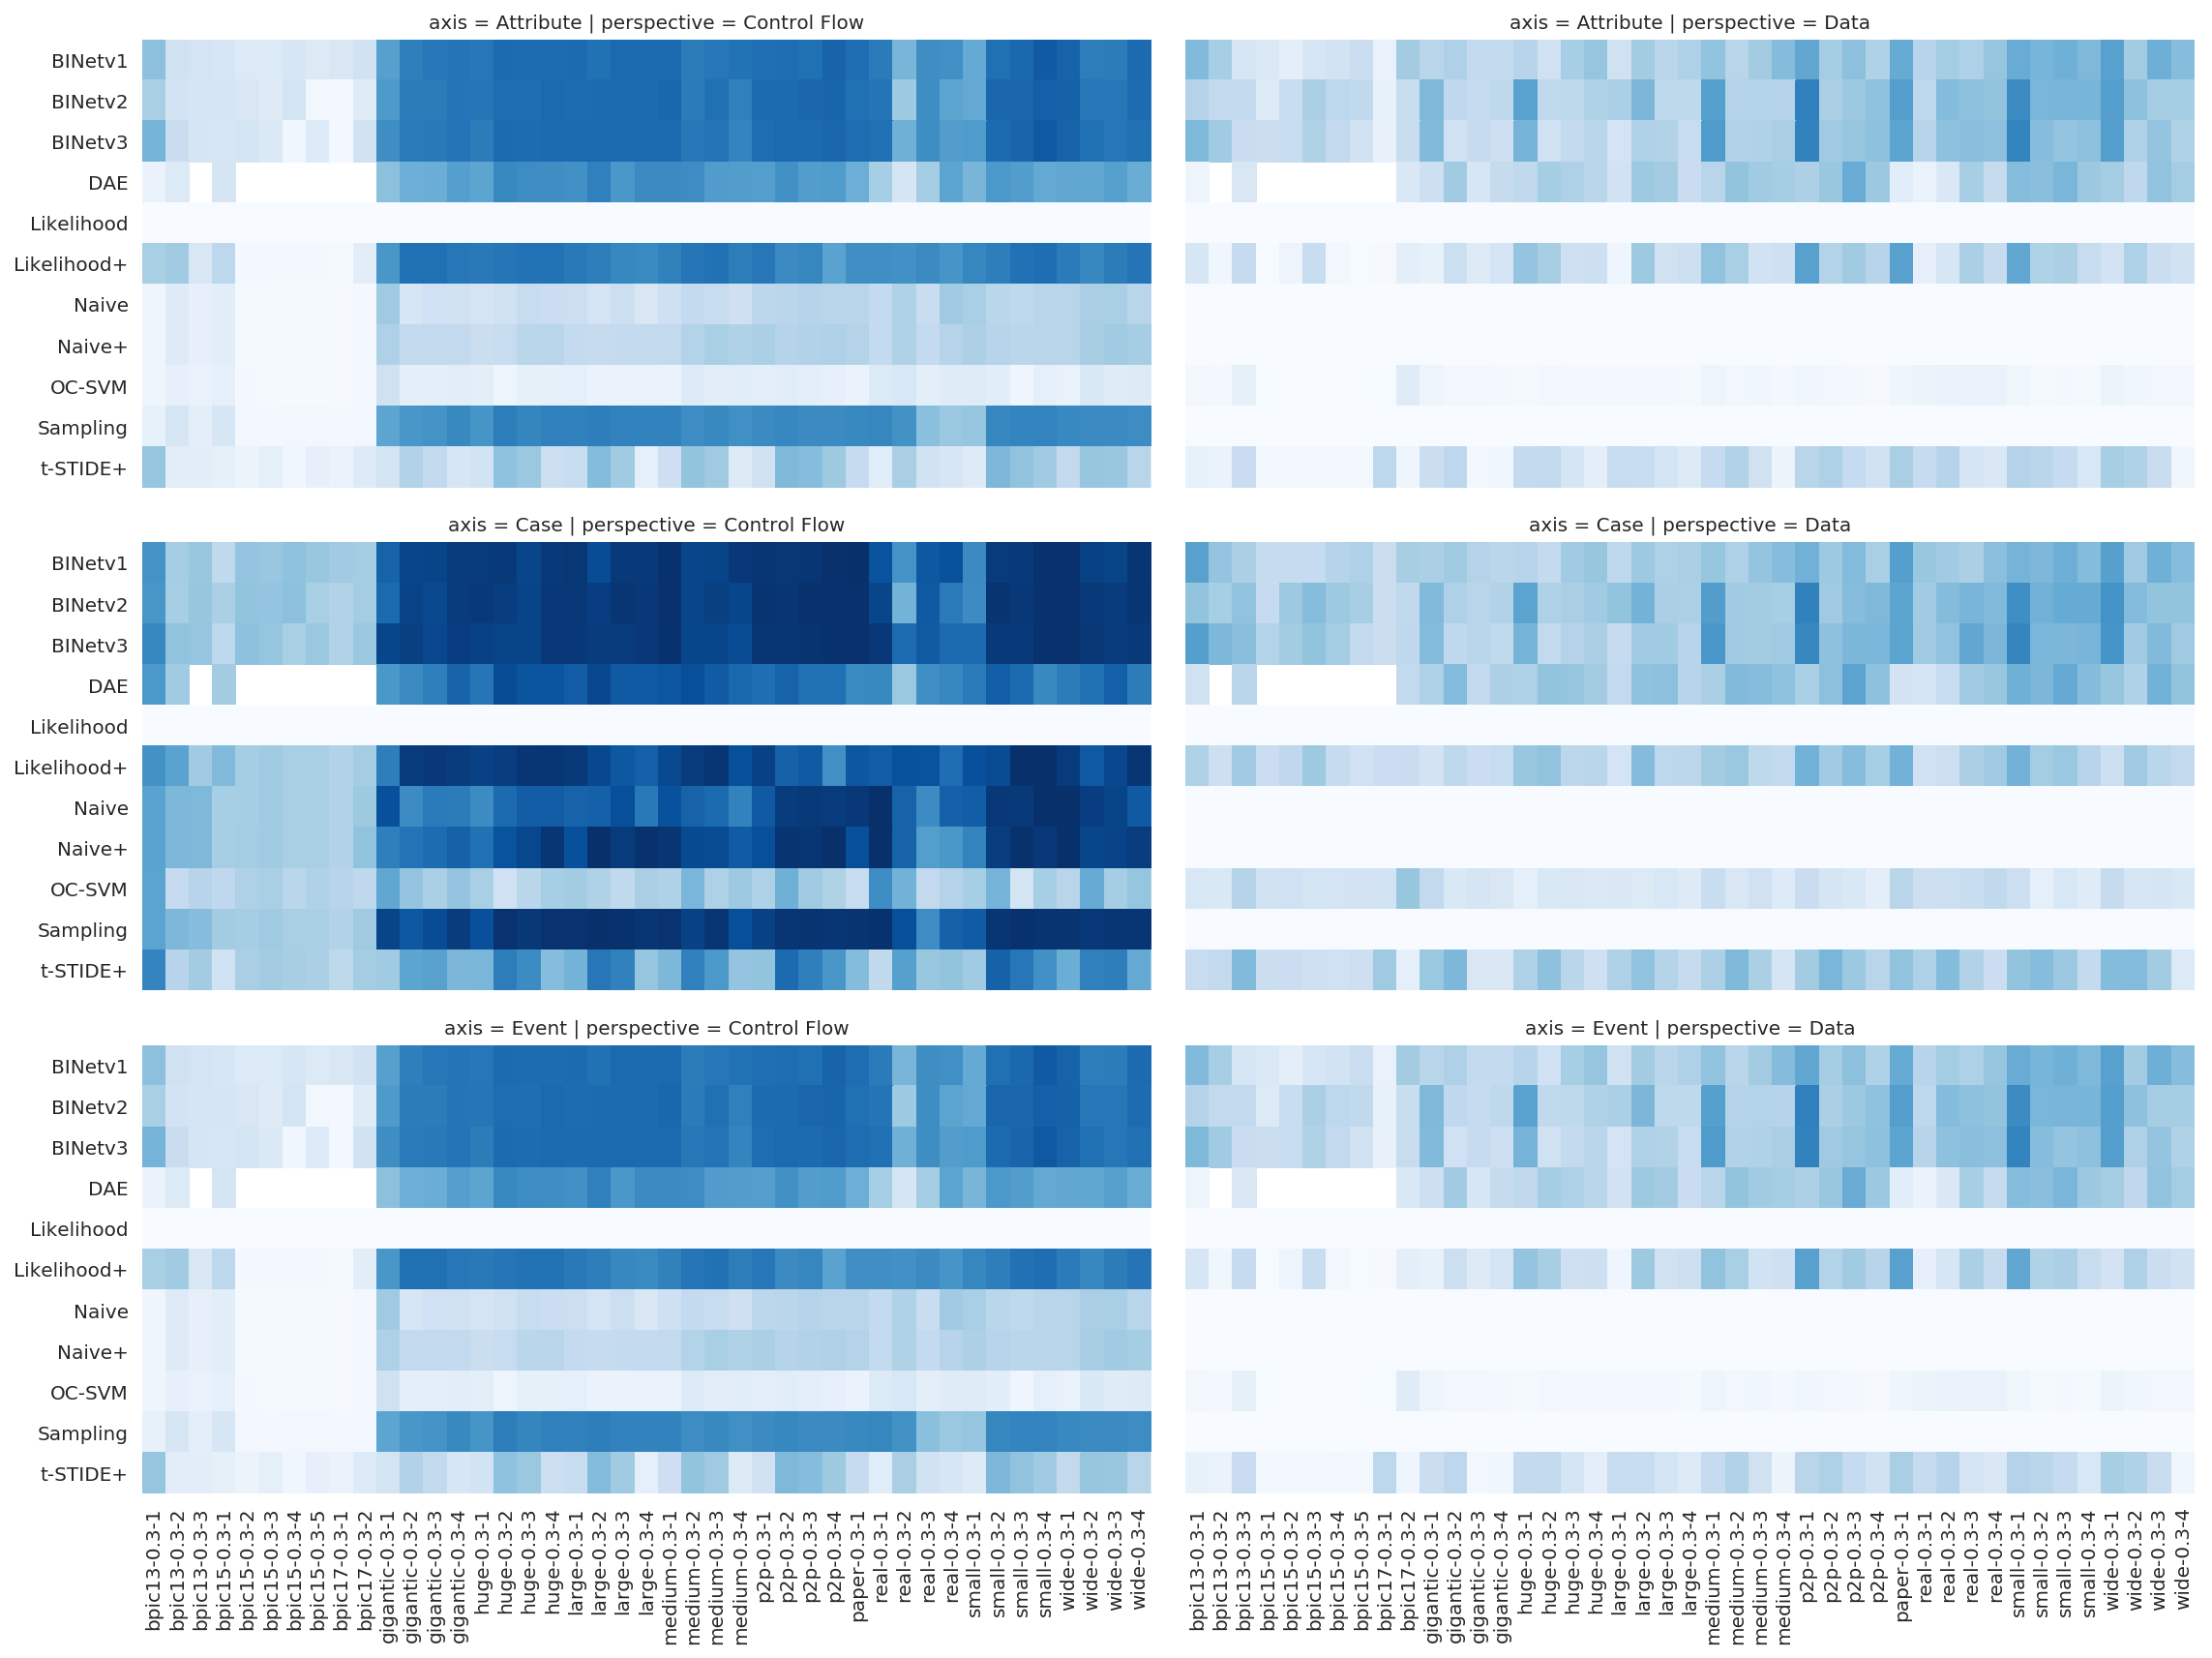

In [14]:
df = filtered_evaluation
df = prettify_dataframe(df)
df = df.groupby(['axis', 'dataset_name', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()

def plot_heatmap(**kwargs):
    df = kwargs.pop('data')
    hm = pd.pivot_table(df, values='f1', index=['ad'], columns=['dataset_name'], aggfunc=np.mean)
    sns.heatmap(hm, **kwargs)
    
g = sns.FacetGrid(data=df, col='perspective', row='axis', sharey=True, sharex=True, despine=False, height=4, aspect=2, margin_titles=False)
g = g.map_dataframe(plot_heatmap, cmap='Blues', vmin=0.0, vmax=1.0, square=False, annot=False, cbar=False, fmt='.2f')

## A3 Training duration

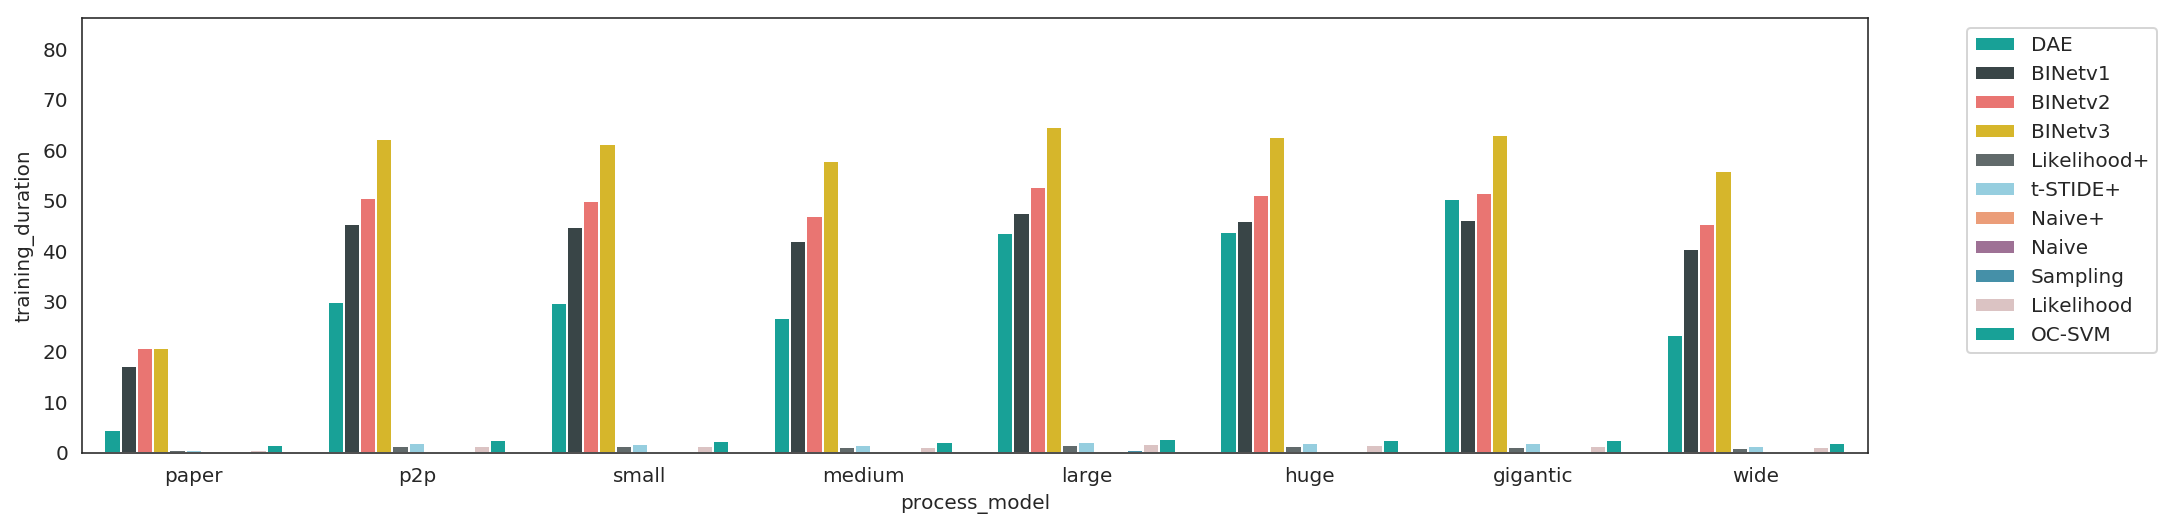

In [15]:
durations = evaluation[['ad', 'dataset_name', 'process_model', 'dataset_type', 'dataset_id', 'training_duration']].drop_duplicates()
durations = durations.query('dataset_type != "bpic"')
fig = plt.subplots(figsize=(16, 4))
g = sns.barplot(data=durations, x='process_model', y='training_duration', hue='ad', palette=microsoft_colors, errwidth=0, hue_order=ads, order=synth_datasets)
g = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)